# **Introduction**

- This workbook attempts to construct a Convlutional Neural Network to classify COVID-19 and Pneumonia using chest x-ray images.

# **Setup**

- Import required packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Generate a `Dataset`**

In [2]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/chest-xray-covid19-pneumonia/Data/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [3]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


# **Visualize the Data**
- First 9 Images from the dataset

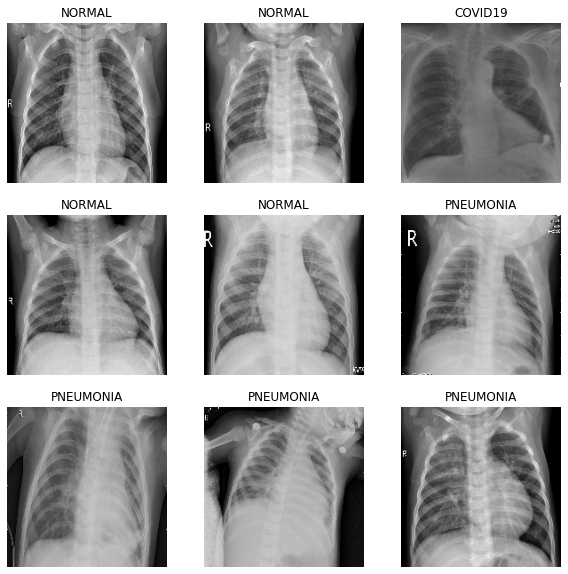

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Image Data Augmentation**

In [6]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

- The images after random augmentation

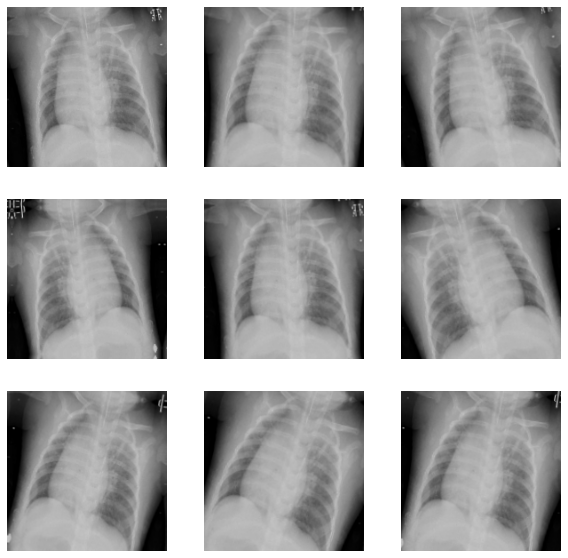

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Configure the dataset for performance**

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# **Build Model**

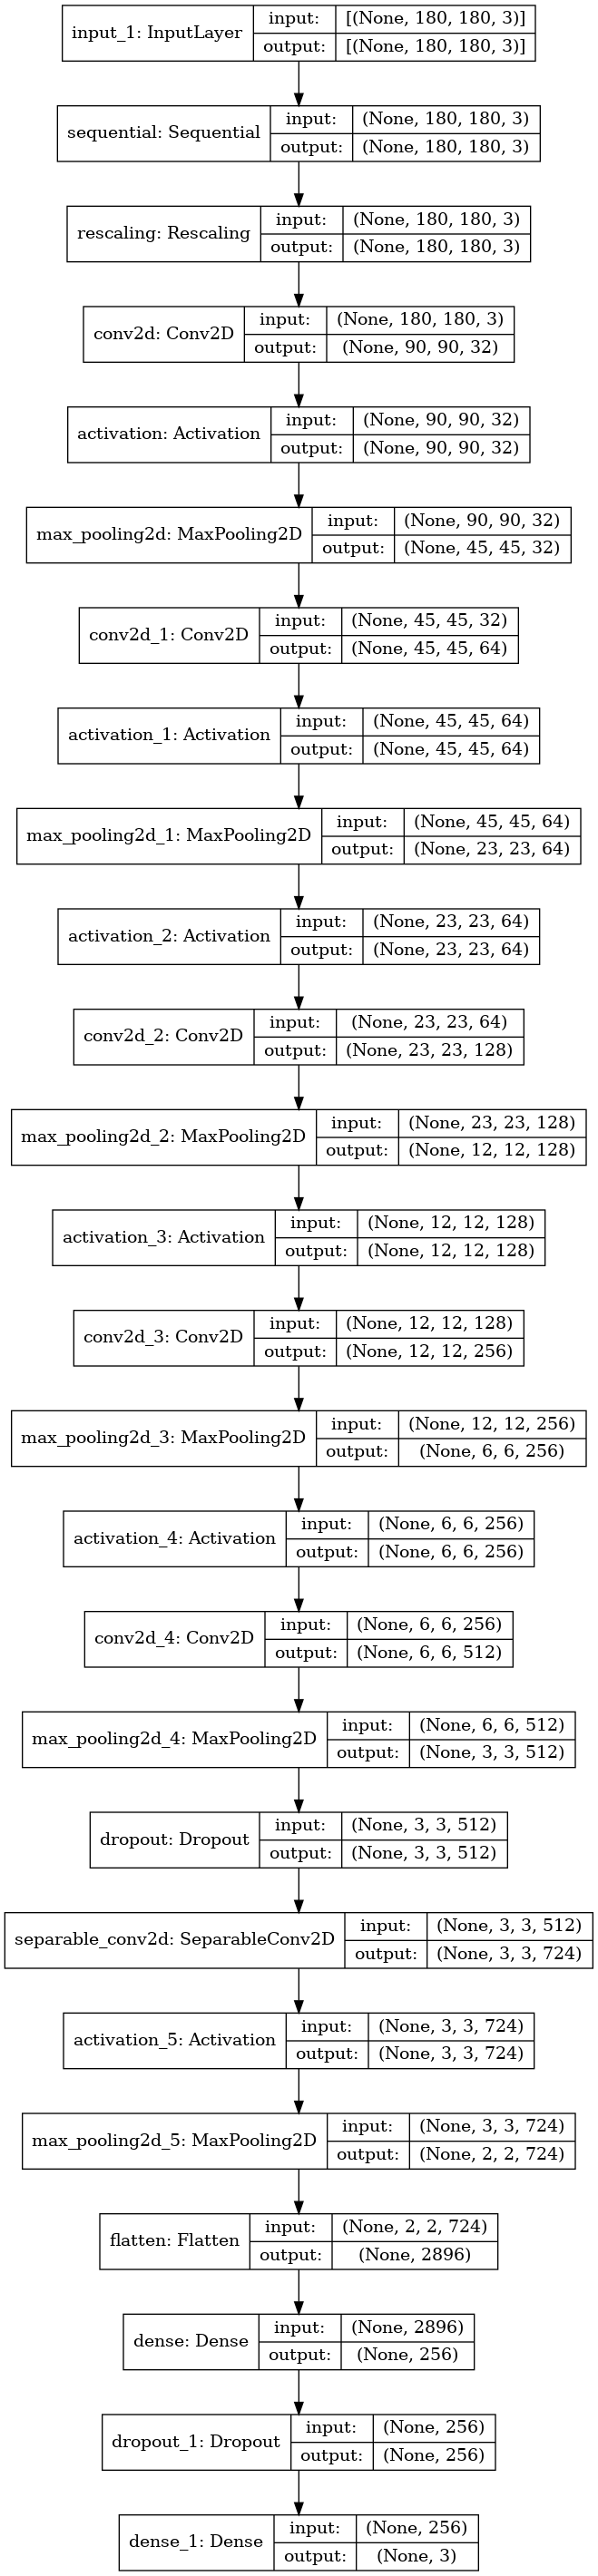

In [9]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

# **Define Callbacks**

In [10]:
# checkpoint_filepath = '/content/content'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# **Train the Model**

In [11]:
epochs = 35

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [early_stop, lr_callback],
    validation_data = val_ds)

Epoch 1/35
129/129 [==============================] - 94s 667ms/step - loss: 1.0105 - accuracy: 0.6139 - val_loss: 0.8461 - val_accuracy: 0.6634
Epoch 2/35
129/129 [==============================] - 44s 332ms/step - loss: 0.7761 - accuracy: 0.6747 - val_loss: 0.6194 - val_accuracy: 0.6916
Epoch 3/35
129/129 [==============================] - 45s 334ms/step - loss: 0.6049 - accuracy: 0.7237 - val_loss: 0.4665 - val_accuracy: 0.7403
Epoch 4/35
129/129 [==============================] - 45s 333ms/step - loss: 0.4582 - accuracy: 0.8171 - val_loss: 0.4113 - val_accuracy: 0.8045
Epoch 5/35
129/129 [==============================] - 44s 331ms/step - loss: 0.3142 - accuracy: 0.8830 - val_loss: 0.2387 - val_accuracy: 0.9008
Epoch 6/35
129/129 [==============================] - 45s 332ms/step - loss: 0.2716 - accuracy: 0.9032 - val_loss: 0.1869 - val_accuracy: 0.9368
Epoch 7/35
129/129 [==============================] - 44s 331ms/step - loss: 0.2474 - accuracy: 0.9153 - val_loss: 0.2138 - val_ac

In [16]:
image_path = "../input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(471).jpg"
image_path2 = "../input/chest-xray-covid19-pneumonia/Data/test/NORMAL/NORMAL(1281).jpg"
image_path3 = "../input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3433).jpg"
merged_path = [image_path,image_path2,image_path3]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to COVID19 with a 57.55 percent confidence.
This image most likely belongs to NORMAL with a 57.59 percent confidence.
This image most likely belongs to PNEUMONIA with a 56.22 percent confidence.
